<a href="https://colab.research.google.com/github/bthorne93/poly-assessment/blob/main/ML_Example/poly_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Instructions for running 

#@markdown This notebook only depends on packages that should already be available in Colab, e.g. `torch` and `torchvision`. During development I used Weights & Biases to track experiments, which requires installing `wandb`. If you want to run this without W&B, uncheck the box below. 


track_with_weights_and_biases = True #@param {type:"boolean"}

In [2]:
if track_with_weights_and_biases:
    !pip install wandb -qU

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST, Flowers102
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, Resize, CenterCrop, RandomCrop
import matplotlib.pyplot as plt
import os 
import math
os.environ["WANDB_NOTEBOOK_NAME"] = "/content/poly-assessment.ipynb"

In [4]:
torch.cuda.is_available()

True

In [5]:
if track_with_weights_and_biases:
    import wandb
    wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /content/poly-assessment.ipynb.
wandb: Currently logged in as: bn-thorne. Use `wandb login --relogin` to force relogin


In [20]:
# Define a Sobel filter function, used to generate the training datasets.
def sobel_filter(img, device="cuda"):
    # Do closest-value padding on image
    img = torch.nn.functional.pad(img, (1, 1, 1, 1), mode="replicate")

    # Define kernels
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=device)
    
    # Reshape kernels for convolution
    sobel_x = sobel_x.view((1, 1, 3, 3)) 
    sobel_y = sobel_y.view((1, 1, 3, 3))

    # Apply kernels to image
    G_x = nn.functional.conv2d(img, sobel_x)
    G_y = nn.functional.conv2d(img, sobel_y)

    # Compute gradient magnitude and direction
    G_mag = torch.sqrt(torch.pow(G_x, 2) + torch.pow(G_y, 2))
    G_dir = torch.atan2(G_y, G_x)

    return G_mag, G_dir
    
# Define custom Sobel dataset class that iterates pairs of input images
# and smoothed images. Assumes data has already been converted into a form
# with a single channel.
class SobelDataset(Dataset):
    def __init__(self, data, device="cuda"):
        self.data = data
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0].to(self.device)
        y, _ = sobel_filter(x, device=self.device)
        return x, y

# Define CNN used to learn Sobel Filter. This is fully convolutional.
class SobelNet(nn.Module):
    def __init__(self, nfilters=3, nhidden=1, kernel_size=3):
        super(SobelNet, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.conv_in = nn.Conv2d(1, nfilters, kernel_size, padding=1, padding_mode="replicate")
        for _ in range(nhidden):
            self.hidden_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding=1, padding_mode="replicate"))
        self.conv_out = nn.Conv2d(nfilters, 1, 1)
    
    def forward(self, x):
        x = torch.relu(self.conv_in(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        return self.conv_out(x)

# Define functions for loading datasets, we have tried MNIST and Flowers102. 

def get_MNIST_data(split, device="cuda", batch_size=32):
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    if split=="train":
        mnist = MNIST('data', train=True, download=True, transform=transform)
        trainset, valset = torch.utils.data.random_split(mnist, [30000, 30000])
        trainloader = DataLoader(SobelDataset(trainset, device=device), batch_size=batch_size, shuffle=True) 
        valloader = DataLoader(SobelDataset(valset, device=device), batch_size=batch_size, shuffle=True)

    elif split=="test":
        testset = MNIST('data', train=False, download=True, transform=transform)
        return DataLoader(SobelDataset(testset), batch_size=batch_size, shuffle=True)
    return 

def get_Flowers102_data(split, device="cuda", batch_size=32):
    "Split should be 'train', 'val' or 'test'."
    transform = Compose([
        Resize(256), 
        CenterCrop(224), 
        Grayscale(num_output_channels=1), 
        ToTensor(),
        Normalize((0.5,), (0.5,))
        ])

    dset = Flowers102('data', split=split, download=True, transform=transform)
    sobel_dset = SobelDataset(dset, device=device)
    return DataLoader(sobel_dset, batch_size=batch_size, shuffle=True)

In [10]:
# This cell contains the code for loading datasets and training the model. 
# The experiments here can be tracked with W&B. 

# Model and training hyperparameters
config = {
        "kernel_size": 3,
        "nfilters": 5,
        "nhidden": 5,
        "epochs": 40,
        "batch_size": 64,
        "lr": 0.01,
        "dataset": "Flowers102"
    }

if track_with_weights_and_biases:
    wandb.init(
        project="poly-interview",
        config=config
    )

# Set device to CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load training and validation datasets
if config["dataset"] == "MNIST":
    train_loader, val_loader = get_MNIST_data("train", device=device, batch_size=config["batch_size"])
if config["dataset"] == "Flowers102":
    train_loader = get_Flowers102_data("train", device=device, batch_size=config["batch_size"])
    val_loader = get_Flowers102_data("val", device=device, batch_size=config["batch_size"])

# Define model
model = SobelNet(nfilters=config["nfilters"], nhidden=config["nhidden"], kernel_size=config["kernel_size"]).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
loss_fn = nn.MSELoss()

# Do training
model.train()
for epoch in range(config["epochs"]):
    running_train_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = loss_fn(outputs, labels)
        train_loss.backward()
        optimizer.step()    
        running_train_loss += train_loss.item()

    with torch.no_grad():
        running_val_loss = 0.
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()

    
    if track_with_weights_and_biases:
        wandb.log({
            "train/train_loss": running_train_loss / len(train_loader), 
            "train/epoch": epoch,
            "val/val_loss": running_val_loss / len(val_loader),
            "val/epoch": epoch
        })

    print(f"Train Loss: {running_train_loss / len(train_loader):.4f}, Val Loss: {running_val_loss / len(val_loader):.4f}")

if track_with_weights_and_biases:
    wandb.finish()

Train Loss: 0.5291, Val Loss: 0.4504
Train Loss: 0.4516, Val Loss: 0.4388
Train Loss: 0.4065, Val Loss: 0.3346
Train Loss: 0.3289, Val Loss: 0.3151
Train Loss: 0.3039, Val Loss: 0.2824
Train Loss: 0.2533, Val Loss: 0.2200
Train Loss: 0.2482, Val Loss: 0.2526
Train Loss: 0.2151, Val Loss: 0.1893
Train Loss: 0.1657, Val Loss: 0.1386
Train Loss: 0.1185, Val Loss: 0.0978
Train Loss: 0.0987, Val Loss: 0.0808
Train Loss: 0.0711, Val Loss: 0.0610
Train Loss: 0.0530, Val Loss: 0.0466
Train Loss: 0.0438, Val Loss: 0.0485
Train Loss: 0.0442, Val Loss: 0.0408
Train Loss: 0.0361, Val Loss: 0.0333
Train Loss: 0.0323, Val Loss: 0.0320
Train Loss: 0.0299, Val Loss: 0.0286
Train Loss: 0.0281, Val Loss: 0.0264
Train Loss: 0.0270, Val Loss: 0.0367
Train Loss: 0.0261, Val Loss: 0.0242
Train Loss: 0.0231, Val Loss: 0.0247
Train Loss: 0.0237, Val Loss: 0.0223
Train Loss: 0.0205, Val Loss: 0.0195
Train Loss: 0.0183, Val Loss: 0.0177
Train Loss: 0.0169, Val Loss: 0.0165
Train Loss: 0.0155, Val Loss: 0.0149
T

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▇▆▅▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/val_loss,██▆▆▅▄▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,39
train/train_loss,0.00915
val/epoch,39
val/val_loss,0.00832


## Testing trained network 

In this section we load the testing split of the relevant dataset and compare some test images to the model's prediction. We also check the learned kernel's performance of images with different dimensions and from different datasets.

### Testing against test holdout of same dataset

In [12]:
# Get test dataset
if config["dataset"] == "MNIST":
    test_loader = get_MNIST_data("test", device="cpu", batch_size=10)
if config["dataset"] == "Flowers102":
    test_loader = get_Flowers102_data("test", device="cpu", batch_size=10)

# Get test batch of inputs and outputs
_, (test_input, test_true) = next(enumerate(test_loader))

# Get batch of predictions
model = model.to("cpu")
model.eval()
with torch.no_grad():
    test_pred = model(test_input)

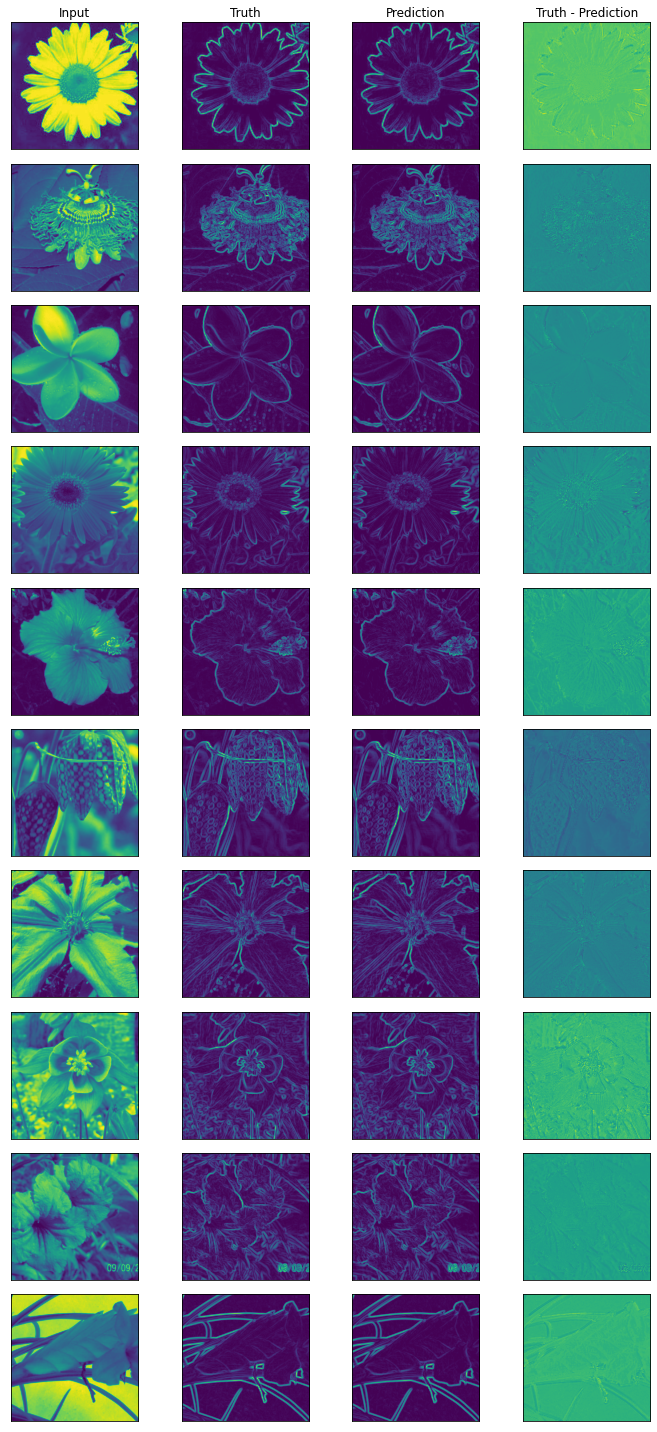

In [13]:
ncols = 4
nrows = len(test_input)
vmin, vmax = None, None

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 2*len(test_input)))
for row in range(nrows):
    for (col, arr, title) in [
                            (0, test_input, "Input"), 
                            (1, test_true, "Truth"), 
                            (2, test_pred, "Prediction"), 
                            (3, test_true - test_pred, "Truth - Prediction")]:
        if row == 0:
            axes[row, col].set_title(title)
        axes[row, col].imshow(arr.squeeze()[row])
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
fig.tight_layout()

### Testing against randomly cropped images from same test set

In [14]:
# Get test batch of inputs and outputs
_, (test_input, test_true) = next(enumerate(test_loader))

test_input_cropped = []
test_true_cropped = []
test_pred_cropped = []
for (_, test_image) in enumerate(test_input):
    transform = Compose([
        RandomCrop((torch.randint(10, 220, (1,))[0], torch.randint(10, 220, (1,))[0] ))
    ])
    test_input_cropped.append(transform(test_image))
    test_true_cropped.append(sobel_filter(test_input_cropped[-1], device="cpu")[0])
    with torch.no_grad():
        test_pred_cropped.append(model(test_input_cropped[-1]))

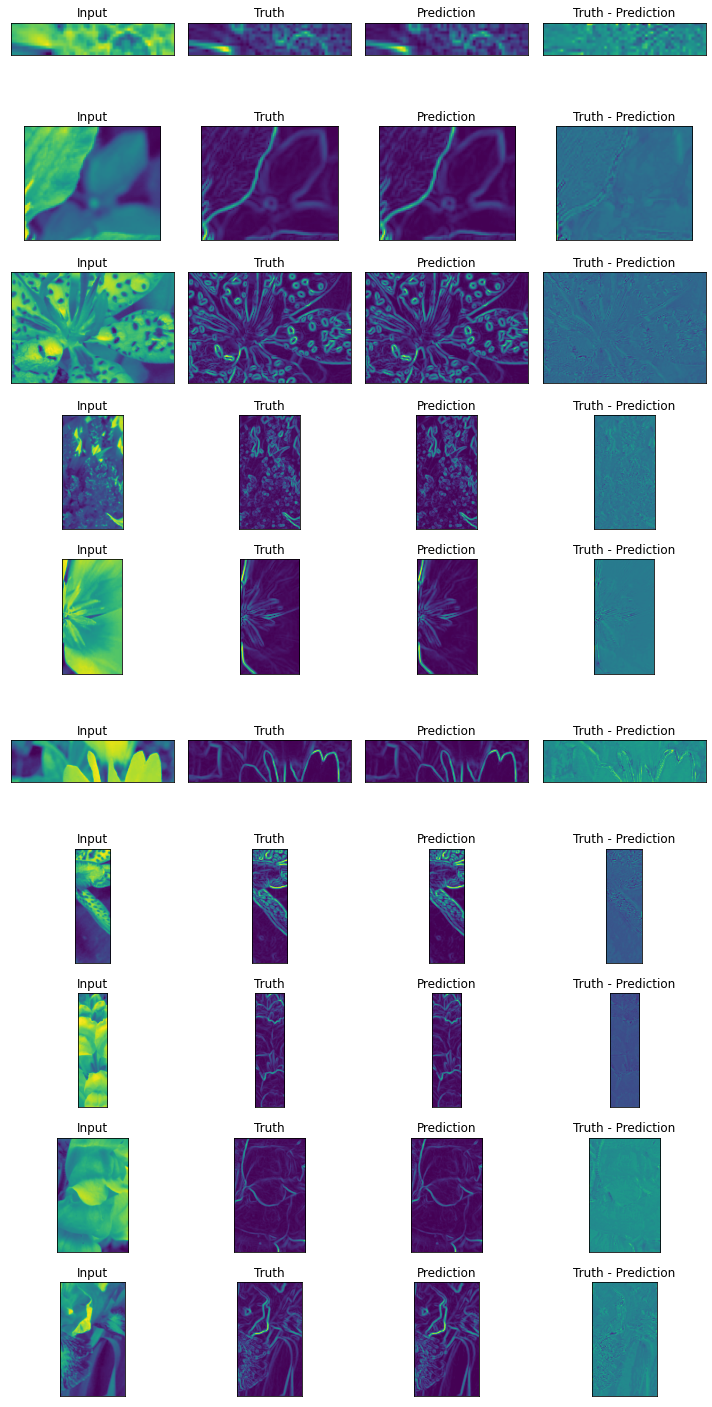

In [15]:
nrows = len(test_true_cropped)
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 2*len(test_input)))
for row in range(nrows):
    for (col, arr, title) in [
                            (0, test_input_cropped[row], "Input"), 
                            (1, test_true_cropped[row], "Truth"), 
                            (2, test_pred_cropped[row], "Prediction"), 
                            (3, test_pred_cropped[row] - test_true_cropped[row], "Truth - Prediction")]:
        axes[row, col].set_title(title)
        axes[row, col].imshow(arr.squeeze())
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
fig.tight_layout()

### Testing against an image from a different dataset

In [16]:
import urllib.request
from PIL import Image

In [17]:
urllib.request.urlretrieve("http://www.lenna.org/lena_std.tif", "image.tif")

('image.tif', <http.client.HTTPMessage at 0x7f4853b80a60>)

In [18]:
img = Image.open("image.tif").convert("L")
transform = Compose(
    [
        Resize(256), 
        CenterCrop(224),
        ToTensor()
    ]
)

test_input = transform(img).unsqueeze(0)
with torch.no_grad():
    test_pred = model(test_input)
test_true = sobel_filter(test_input, device="cpu")[0]


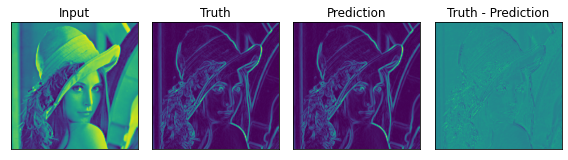

In [19]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 3))

for (col, arr, title) in [
                        (0, test_input, "Input"), 
                        (1, test_true, "Truth"), 
                        (2, test_pred, "Prediction"), 
                        (3, test_true - test_pred, "Truth - Prediction")]:
    axes[col].set_title(title)
    axes[col].imshow(arr.squeeze())
    axes[col].set_xticks([])
    axes[col].set_yticks([])
fig.tight_layout()

# Questions

1. What if the image is really large or not of a standard size?

The model we are developing here is a convolutional model, which does not require a fixed input size, and so can be applied to inputs of various sizes and shapes, as demonstrated above. 


2. What should occur at the edges of the image?

In order to maintain image dimensions we have to apply padding to the image boundaries. As the Sobel filter is effectively an estimator of the gradients in the image, I decided to use a padding that extends the image using the closest pixel value. Alternative choices, such as a constant value of 0 could introduce large gradients in pixel value, which would be picked up by the Sobel filter. 

3. Are you using a fully convolutional architecture?

I am using a fully convolutional architecture. 

4. Are there optimizations built into your framework of choice (e.g. Pytorch) that can make this fast?

Pytorch is already designed to implement optimized convolution operations on GPUs using low-level CUDA and cuDNN libraries, which this approach will use. 

5. What if you wanted to optimize specifically for model size?

The Sobel filter is relatively simple: just two linear convolutions defined by 3x3 kernels, and a couple of non-linear operations. The complexity of the simple network I implemented could probably be reduced further with careful consideration of how to capture the non-linear aspects of the Sobel filter, or by implementing them by hand. 

6. How do you know when training is complete?

One can choose how to define the end of training. I would choose to satisfy the following criteria: 

- Predefine a required level of validation set accuracy below which we are satisfied with the model's performance. 
- Once this level is reached, no further improvements for ~5 epochs of training.
- Validation and training losses are comparable. 

7. What is the benefit of a deeper model in this case? When might there be a benefit for a deeper model (not with a sobel kernel but generally when thinking about image to image transformations)?

In this case, a deeper mdoel may not provide significant improvements, as the model we are learning is relatively simple. In general, though, deeper architectures are able to better learn the hierarchical relationships between features in a given image as they have a larger receptive field for deeper layers. This allows the network to learn more abstract relationships between high-level features. Furthermore, the larger capacity of the network would be able to accommodate a wider range of image types, styles, and content. So for general image-to-image tasks such as image segmentation, deeper networks would perform much better.